In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
import glob,os
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
datapath="/work/FAC/FGSE/IDYST/tbeucler/default/saranya/Data/ECMWF/ERA5_25kmx3hr/"
path="/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/besttracks/wp/"
target="/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/create_ts/outputs/targets/"

#ds0=xr.open_dataset(datapath+'prate/tot_prec_2021.nc')


Total Integrated Precip.

In [147]:
!ls /work/FAC/FGSE/IDYST/tbeucler/default/saranya/Data/ECMWF/ERA5_25kmx3hr/prate

prates_2000.nc	prates_2007.nc	prates_2014.nc	prates_2021.nc
prates_2001.nc	prates_2008.nc	prates_2015.nc	totprec_2001_2010.nc
prates_2002.nc	prates_2009.nc	prates_2016.nc	totprec_2011_2020.nc
prates_2003.nc	prates_2010.nc	prates_2017.nc	tot_prec_2021.nc
prates_2004.nc	prates_2011.nc	prates_2018.nc
prates_2005.nc	prates_2012.nc	prates_2019.nc
prates_2006.nc	prates_2013.nc	prates_2020.nc


In [148]:
track = sorted(glob.glob(path+'wp_2021.csv'))

In [150]:

tracksDF = pd.read_csv(track[0])
stormname = tracksDF['name'].unique()

In [151]:
stormname

array(['CHAMPI', 'IN-FA', 'LUPIT', 'OMAIS', 'CONSON', 'CHANTHU', 'RAI'],
      dtype=object)

In [152]:
##########function############
def output_indices(TCtrack=None,ERA5date=None,ERA5hour=None):
    allindices = []
    for timeidx in range(len(TCtrack)):#len(track['time'])):
        datetrack,hourtrack = TCtrack['time'][timeidx].split(':')[0],TCtrack['time'][timeidx].split(':')[1][0:2]
        ####################################################################################################
        # Find the indices in ERA5 data with the same date as track
        ####################################################################################################
        dateind = []
        for ind,obj in enumerate(ERA5date):
            if obj==datetrack:
                dateind.append(ind)
        del ind,obj
        hourind = []
        hourextract = ERA5hour[int(np.min(np.asarray(dateind))):int(np.max(np.asarray(dateind)))+1]
        for ind,obj in enumerate(hourextract):
            if obj==hourtrack:            
                hourind.append(ind)
        allindices.append((int(np.min(np.asarray(dateind))),int(hourind[0])))
    return allindices

def extract_var(dataset=None,var='var138',indices=None):
    extractedvar = []
    for i in (range(len(indices))):
        realindex = indices[i][0]+indices[i][1]
        extractedvar.append(dataset[var][int(realindex),...].data)
    return np.asarray(extractedvar)

def extract_varnotransform(dataset=None,var='var138',indices=None):
    extractedvar = []
    for i in (range(len(indices))):
        realindex = indices[i][0]+indices[i][1]
        extractedvar.append(dataset[var][int(realindex),...])
    return (extractedvar)

def smallarea(dataset=None,invar=None,indices=None,tc_irad=None):
    if len(invar.shape) != 3:
        invar = np.squeeze(invar)
    ds = xr.Dataset(
    data_vars=dict(variable=(["time","lat","lon"], invar)),#mysvar[0])),
    coords=dict(lat=(["lat"], dataset.lat.data),lon=(["lon"], dataset.lon.data),time=(["time"], np.linspace(0,len(indices)-1,len(indices)))),
    attrs=dict(description="coords with matrices"),)
    
    LATN,LATS,LONE,LONW = tc_irad[0,:]
    testsmall = ds['variable'][0,:,:].sel(lat=slice(LATS,LATN),lon=slice(LONE,LONW))
    if testsmall.shape[0]<testsmall.shape[1]:
        rgspt = int(testsmall.shape[0])
    else:
        rgspt = int(testsmall.shape[1])
    rgspt=16
    var_out=np.zeros((len(indices),rgspt,rgspt))
    del testsmall
    
    for it in range(len(indices)):
        latn, lats, lone, lonw = tc_irad[it,:]
        try:
            var_out[it,:,:]=ds['variable'][it,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))
        except:
            var_out[it,:,:]=ds['variable'][it,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:rgspt,0:rgspt]
    return var_out

def largearea_withpres(dataset=None,invar=None,indices=None,tc_irad=None,rgspthard=16):
    ds = xr.Dataset(
    data_vars=dict(variable=(["time","plev","lat","lon"], invar)),#mysvar[0])),
    coords=dict(lat=(["lat"], dataset.lat.data),lon=(["lon"], dataset.lon.data),time=(["time"], np.linspace(0,len(indices)-1,len(indices))),
               plev=(["plev"],dataset.plev.data)),
    attrs=dict(description="coords with matrices"),)
    
    LATN,LATS,LONE,LONW = tc_irad[0,:]
    testsmall = ds['variable'][0,0,:,:].sel(lat=slice(LATS,LATN),lon=slice(LONE,LONW))
    if testsmall.shape[0]<testsmall.shape[1]:
        rgspt = int(testsmall.shape[0])
    else:
        rgspt = int(testsmall.shape[1])
    rgspt=rgspthard
    var_out=np.zeros((len(indices),len(dataset.plev.data),rgspt,rgspt))
    del testsmall
    
    for it in range(len(indices)):
        latn, lats, lone, lonw = tc_irad[it,:]
        for ip in range(len(dm1.plev.data)):
            try:
                var_out[it,ip,:,:]=ds['variable'][it,ip,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))
            except:
                var_out[it,ip,:,:]=ds['variable'][it,ip,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:rgspt,0:rgspt]
    return var_out

In [153]:
def readyear_automatic(raindata=None,year=None):
    dm2 = xr.open_dataset(datapath+'/slev_vars/svars_'+str(year)+'.nc')
    #tracklist = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/besttracks/nio/*_'+str(year)+'*'))
    era5_date = [str(dm2.time[i].data).split('T')[0] for i in range(len(dm2.time))]
    era5_hour = [str(dm2.time[i].data).split('T')[1][0:2] for i in range(len(dm2.time))]
    
    era5_raindate = [str(raindata.time[i].data).split('T')[0] for i in range(len(raindata.time))]
    era5_rainhour = [str(raindata.time[i].data).split('T')[1][0:2] for i in range(len(raindata.time))]
    return dm2,era5_date,era5_hour,era5_raindate,era5_rainhour

dm_svar,svar_date,svar_hour,rain_date,rain_hour = readyear_automatic(ds0,2021)

In [154]:
#for dm1 files functions
def make_timeseries_step1(TCname=None,era5_date=None,era5_hour=None):
    track=tracksDF[tracksDF['name']==TCname].reset_index()
    lon1=track['lon'].to_numpy()
    lat1=track['lat'].to_numpy()
    pos = np.stack((lat1, lon1), axis=1)
    ###########################################################################
    indices_store = output_indices(track,era5_date,era5_hour)
    ###########################################################################
    tc_irad=np.empty((len(indices_store),4))
    tc_irad[:,0] = pos[:,0]-5
    tc_irad[:,1] = pos[:,0]+5
    tc_irad[:,2] = pos[:,1]-5
    tc_irad[:,3] = pos[:,1]+5
    return pos,indices_store,tc_irad

def make_timeseries_step3(dm1=None,pvarname=None,pvardict=None,indices_store=None):
    ts_pdict = {}
    for ind,obj in (enumerate(pvarname)):
        pvarTS_store = []
        for plevv in range(len(dm1.plev.data)):
            tempvar = pvardict[pvarname[ind]][:,plevv,...]
            tempts = [tempvar[i,...].flatten() for i in range(len(indices_store))]
            tempTSERIES = [np.nanmean(obj) for obj in tempts]
            pvarTS_store.append(tempTSERIES)
        ts_pdict[pvarname[ind]] = np.asarray(pvarTS_store).transpose()
    return ts_pdict

def preproc_integration(array_precip=None,array_cloud=None,cloudmaskvalue=None):
    pprm = array_precip.copy().flatten()
    pprm[array_cloud.copy().flatten()<cloudmaskvalue] = 0
    return pprm.reshape(array_precip.shape)

In [155]:
#precipitation target
from tqdm import tqdm
TCprecip_ts = []
for TCname in tqdm(stormname):
    ###########################################################################
    pos,indices_store,tc_irad = make_timeseries_step1(TCname=TCname,era5_date=svar_date,era5_hour=svar_hour)
    _,rainindices_store,_ = make_timeseries_step1(TCname=TCname,era5_date=rain_date,era5_hour=rain_hour)
    
    svar0 = extract_varnotransform(dataset=dm_svar,var='var79',indices=indices_store)
    svar1 = extract_varnotransform(dataset=dm_svar,var='var78',indices=indices_store)
    clouds = svar0+svar1
    
    precip = extract_varnotransform(dataset=ds0,var='var228',indices=rainindices_store)
    
    ppr=np.zeros((pos.shape[0],40,40))
    pp=np.zeros((tc_irad.shape[0],))
    ppm=np.zeros((tc_irad.shape[0],))
    ppmaskcloud = np.zeros((pos.shape[0],40,40))
    for it in range(tc_irad.shape[0]):
        #precip_nan=precip.where(precip>0, other='nan')
        latn, lats, lone, lonw = tc_irad[it,:]
        ppr[it,:,:]=precip[it].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:40,0:40]
        ppmaskcloud[it,:,:]=clouds[it].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:40,0:40]
        ppm[it]=np.nanmax(ppr[it,:,:])*1000
    ###########################################################################
    cloudmaskvalue = np.nanpercentile(ppmaskcloud[...].flatten(),10)
    masked_precip = [preproc_integration(ppr[i,...],ppmaskcloud[i,...],cloudmaskvalue) for i in range(ppr.shape[0])]
    p=(np.trapz(np.trapz(np.asarray(masked_precip),dx=25,axis=1),dx=25,axis=1))
    ###########################################################################
    smallpvarout = [ppm,p]
    pvarname = ['tot_Prec_max','tot_Prec_Intg']
    pvardict = {varnameobj:varobj for (varnameobj,varobj) in zip(pvarname,smallpvarout)}
    #ts_pdict = make_timeseries_step3(dm1=dm1,pvarname=pvarname,pvardict=pvardict,indices_store=indices_store)
    #############################################################################################
    TCprecip_ts.append(pvardict)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.00s/it]


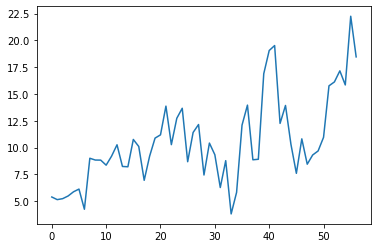

In [156]:
plt.plot(TCprecip_ts[0]['tot_Prec_max'])
plt.show()

In [157]:
! cat /work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/create_ts/outputs/targets/2003

cat: /work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/create_ts/outputs/targets/2003: No such file or directory


In [158]:
storeTCdicts = {}
for ind in range(len(TCprecip_ts)):
    storeTCdicts[stormname[ind]] = pd.DataFrame.from_dict(TCprecip_ts[ind])

In [159]:
for ind,obj in enumerate(stormname):
    storeTCdicts[obj].to_csv(target+'2021_precipvar_wpac_2021'+str(obj)+'.csv')

The script ends here!!